<a href="https://colab.research.google.com/github/hugorodro/auto_encoders/blob/main/autoencoder_itl_regularizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%black

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from scipy.ndimage.filters import gaussian_filter

import tensorflow as tf
import tensorflow.math as tm 
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [ ]:
# %%black

# load data
load_prefix = '/content/gdrive/My Drive/KMNIST_Dataset/'
train_images = (
    np.load('{}kmnist-train-imgs.npz'.format(load_prefix))['arr_0'] / 255)
test_images = np.load(
    '{}kmnist-test-imgs.npz'.format(load_prefix))['arr_0'] / 255
train_labels = np.load(
    '{}kmnist-train-labels.npz'.format(load_prefix))['arr_0'].reshape(-1)
test_labels = np.load(
    '{}kmnist-test-labels.npz'.format(load_prefix))['arr_0'].reshape(-1)

# one hot encode labels
ohc = OneHotEncoder(sparse=False)
train_labels_one_hot = ohc.fit_transform(train_labels.reshape(-1, 1)).astype(int)


# blur training data
blurry_train_images = np.zeros(train_images.shape)
for i, img in enumerate(train_images):
    blurry_train_images[i] = gaussian_filter(img, 1)

In [ ]:
# %%black

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(800, activation='relu',  ),
            layers.BatchNormalization(),
            layers.Dense(400, activation='relu', ),
            layers.BatchNormalization(),
            layers.Dense(latent_dim, activation='relu', ),
            layers.BatchNormalization(),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(400, activation='relu', ),
            layers.BatchNormalization(),
            layers.Dense(800, activation='relu',),
            layers.BatchNormalization(),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])
        

    def call(self, x):
        # breakpoint()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def train_autoencoder(X_train, y_train, X_val, y_val, latent_dim, lr, epoch, verbose):
  autoencoder= Autoencoder(latent_dim)
  autoencoder.compile(
      optimizer=optimizers.Adam(learning_rate=lr),
      loss=losses.MeanSquaredError(), #MyLoss(),
  )

  history = autoencoder.fit(
      X_train, y_train, 
      validation_data=(X_val, y_val), 
      epochs=epoch,
      shuffle=True,
      # callbacks=[tf.keras.callbacks.EarlyStopping(
      #     monitor='val_loss', min_delta=0, patience=2, verbose=verbose,
      #     mode='auto', baseline=None, restore_best_weights=True
      # )
      # ]
  )
  if verbose == 1:

      # Plot Traing Loss vs Iteration
      plt.subplot(211)
      plt.title('Cross Entropy Loss')
      plt.plot(history.history['loss'], color='blue', label='train')
      plt.plot(history.history['val_loss'], color='orange', label='validation')
      plt.legend(loc="upper right")
      plt.savefig('cross_entropy_loss.png')
      plt.show()
      plt.close()


  return autoencoder, history.history['loss'], history.history['val_loss']

class MyLoss(losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        n = y_true.shape.as_list()[0]
        e = tm.subtract(y_true, y_pred)
        bw = tm.reduce_std(e)
        g_coeff = 1 / bw * math.sqrt(2*math.pi)

        ei = tf.reshape(e, [n, 1])
        ej = tf.reshape(e, [1, n])
        e_delta = tf.matmul(ei, -ej)

        innner = tf.multiply(g_coeff,  tm.exp(
            tm.multiply(tm.square(tm.divide(e_delta, bw)), -.5)))
        mean1 = tf.math.reduce_mean(innner, axis=0)
        mean2 = tf.math.reduce_mean(mean1, axis=0)

        i2 = tm.multiply(tf.constant(1 / n**2), mean2)
        h2 = (-1)*tm.log(i2)
        return h2


DIMENSION: 3 K-FOLD: 1
Epoch 1/10
1250/1250 [==============================] - 36s 27ms/step - loss: 0.0927 - val_loss: 0.0787
Epoch 2/10
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0787 - val_loss: 0.0741
Epoch 3/10
1250/1250 [==============================] - 34s 27ms/step - loss: 0.0760 - val_loss: 0.0731
Epoch 4/10
1250/1250 [==============================] - 33s 27ms/step - loss: 0.0744 - val_loss: 0.0713
Epoch 5/10
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0730 - val_loss: 0.0704
Epoch 6/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.0720 - val_loss: 0.0696
Epoch 7/10
1250/1250 [==============================] - 32s 25ms/step - loss: 0.0711 - val_loss: 0.0682
Epoch 8/10
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0706 - val_loss: 0.0682
Epoch 9/10
1250/1250 [==============================] - 32s 26ms/step - loss: 0.0700 - val_loss: 0.0675
Epoch 10/10
1250/1250 [==================

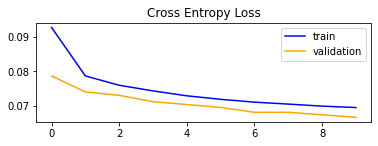

In [ ]:
# %%black

n_samples = train_labels.shape[0]
X = train_images
y = train_images
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, y)

# print(skf)
learning_rate = .001
verbose = 1
enc_dimensions = [3]
epoch = 10
train_losses = []
val_losses = []
ae = None
for dim in enc_dimensions:
    dim_train_losses = []
    dim_val_losses = []
    count = 0
    for train_index, val_index in skf.split(np.zeros(n_samples), train_labels):
        count+=1
        print('DIMENSION:', dim, 'K-FOLD:', count)

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        autoencoder, train_loss, val_loss = train_autoencoder(X_train, y_train, X_val, y_val, dim, learning_rate, epoch, verbose)

        dim_train_losses.append(train_loss)
        dim_val_losses.append(val_loss)

        ae = autoencoder
        break
  
train_losses.append(dim_train_losses)
val_losses.append(dim_val_losses)

Computing LLE embedding
Done. Reconstruction error: 1.43047e-09


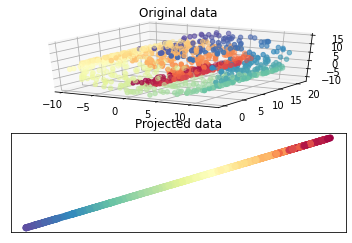

In [ ]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause (C) INRIA 2011

import matplotlib.pyplot as plt

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D

Axes3D

# ----------------------------------------------------------------------
# Locally linear embedding of the swiss roll

from sklearn import manifold, datasets

X, color = datasets.make_swiss_roll(n_samples=1000)

print("Computing LLE embedding")
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=10, n_components=1, )
print("Done. Reconstruction error: %g" % err)

# ----------------------------------------------------------------------
# Plot result

fig = plt.figure()

ax = fig.add_subplot(211, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_r, X_r, c=color, cmap=plt.cm.Spectral)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("Projected data")
plt.show()